## Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
import heapq
from nltk.tokenize import RegexpTokenizer 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.optimizers import RMSprop
import pickle

## Load and Process Text Corpus

In [2]:
path = ("1661-0.txt")
df = open(path, 'r', encoding = 'utf8').read().lower()

In [3]:
df

'\ufeff\nproject gutenberg\'s the adventures of sherlock holmes, by arthur conan doyle\n\nthis ebook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  you may copy it, give it away or\nre-use it under the terms of the project gutenberg license included\nwith this ebook or online at www.gutenberg.net\n\n\ntitle: the adventures of sherlock holmes\n\nauthor: arthur conan doyle\n\nrelease date: november 29, 2002 [ebook #1661]\nlast updated: may 20, 2019\n\nlanguage: english\n\ncharacter set encoding: utf-8\n\n*** start of this project gutenberg ebook the adventures of sherlock holmes ***\n\n\n\nproduced by an anonymous project gutenberg volunteer and jose menendez\n\n\n\ncover\n\n\n\nthe adventures of sherlock holmes\n\n\n\nby arthur conan doyle\n\n\n\ncontents\n\n\n   i.     a scandal in bohemia\n   ii.    the red-headed league\n   iii.   a case of identity\n   iv.    the boscombe valley mystery\n   v.     the five orange pips\n   vi.    the man wi

In [4]:
corpus_len = len(df)
print("Corpus Lenth: ", corpus_len)

Corpus Lenth:  581888


In [5]:
file = open(path, 'r', encoding = 'utf8')
lines = []

for line in file:
    lines.append(line)
print(lines)

['\ufeff\n', "Project Gutenberg's The Adventures of Sherlock Holmes, by Arthur Conan Doyle\n", '\n', 'This eBook is for the use of anyone anywhere at no cost and with\n', 'almost no restrictions whatsoever.  You may copy it, give it away or\n', 're-use it under the terms of the Project Gutenberg License included\n', 'with this eBook or online at www.gutenberg.net\n', '\n', '\n', 'Title: The Adventures of Sherlock Holmes\n', '\n', 'Author: Arthur Conan Doyle\n', '\n', 'Release Date: November 29, 2002 [EBook #1661]\n', 'Last Updated: May 20, 2019\n', '\n', 'Language: English\n', '\n', 'Character set encoding: UTF-8\n', '\n', '*** START OF THIS PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK HOLMES ***\n', '\n', '\n', '\n', 'Produced by an anonymous Project Gutenberg volunteer and Jose Menendez\n', '\n', '\n', '\n', 'cover\n', '\n', '\n', '\n', 'The Adventures of Sherlock Holmes\n', '\n', '\n', '\n', 'by Arthur Conan Doyle\n', '\n', '\n', '\n', 'Contents\n', '\n', '\n', '   I.     A Sc

## Tokenization and Vocabulary Creation

In [6]:
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(df)
print(words[:50], sep = " ")

['project', 'gutenberg', 's', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur', 'conan', 'doyle', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're', 'use', 'it', 'under', 'the', 'terms', 'of', 'the', 'project', 'gutenberg', 'license', 'included']


In [7]:
unique_words = np.unique(words)
unique_words_index = dict((c,i) for c,i in enumerate(unique_words))
print(unique_words_index, sep = " ")

{0: '0', 1: '000', 2: '1', 3: '10', 4: '100', 5: '1000', 6: '10_s_', 7: '10th', 8: '11', 9: '117', 10: '120', 11: '12_s_', 12: '12th', 13: '14', 14: '140', 15: '15', 16: '150', 17: '1500', 18: '1661', 19: '16a', 20: '17', 21: '1846', 22: '1858', 23: '1869', 24: '1870', 25: '1878', 26: '1883', 27: '1884', 28: '1887', 29: '1888', 30: '1890', 31: '19th', 32: '1_s_', 33: '2', 34: '20', 35: '200', 36: '2001', 37: '2002', 38: '2019', 39: '220', 40: '221b', 41: '226', 42: '22nd', 43: '249', 44: '25', 45: '250', 46: '26', 47: '26_s_', 48: '27', 49: '270', 50: '29', 51: '2_s_', 52: '2nd', 53: '3', 54: '30', 55: '31', 56: '35', 57: '3rd', 58: '4', 59: '40', 60: '4000', 61: '421', 62: '4700', 63: '4_d_', 64: '4th', 65: '4½', 66: '5', 67: '50', 68: '501', 69: '596', 70: '6', 71: '60', 72: '6221541', 73: '64', 74: '6_d_', 75: '7', 76: '700', 77: '750', 78: '750175', 79: '77', 80: '7_s_', 81: '7th', 82: '8', 83: '801', 84: '809', 85: '82', 86: '83', 87: '84', 88: '84116', 89: '85', 90: '87', 91: '88

In [8]:
character = sorted(list(set(df)))
character_indices = dict((c,i) for i,c in enumerate(character))
indices_character = dict((i,c) for i,c in enumerate(character))
print(f"unique characters : {len(character)}")

unique characters : 73


## Data Preparation for Training

In [9]:
sequence_length = 40
step = 3
sentences = []
next_chars = []
for i in range (0, len(df) - sequence_length, step):
    sentences.append(df[i: i + sequence_length])
    next_chars.append(df[i + sequence_length])
print(f'num training examples: {len(sentences)}')

num training examples: 193950


In [10]:
X = np.zeros((len(sentences), sequence_length, len(character)), dtype = bool)
Y = np.zeros((len(sentences), len(character)), dtype = bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, character_indices[char]] = 1
    Y[i, character_indices[next_chars[i]]] = 1

In [11]:
sentences[124]

'\nauthor: arthur conan doyle\n\nrelease dat'

In [12]:
next_chars[100]

'e'

In [13]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True])

In [14]:
Y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [15]:
X.shape

(193950, 40, 73)

In [16]:
Y.shape

(193950, 73)

## Build LSTM Model

In [17]:
model = Sequential()
model.add(LSTM(128, input_shape = (sequence_length, len(character))))
model.add(Dense(len(character)))
model.add(Activation('softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               103424    
                                                                 
 dense (Dense)               (None, 73)                9417      
                                                                 
 activation (Activation)     (None, 73)                0         
                                                                 
Total params: 112841 (440.79 KB)
Trainable params: 112841 (440.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


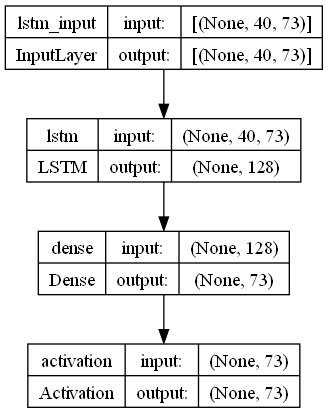

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True, to_file = 'nextwordmodel.png')

## Model Training and Evaluation

In [20]:
optimizer = RMSprop(learning_rate = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
history = model.fit(X,Y, validation_split = 0.01, batch_size = 128, epochs = 20, shuffle = True).history

Epoch 1/20
1501/1501 [==============================] - 170s 109ms/step - loss: 2.0372 - accuracy: 0.4028 - val_loss: 2.2243 - val_accuracy: 0.3634
Epoch 2/20
1501/1501 [==============================] - 163s 109ms/step - loss: 1.6644 - accuracy: 0.5020 - val_loss: 2.0966 - val_accuracy: 0.4237
Epoch 3/20
1501/1501 [==============================] - 146s 97ms/step - loss: 1.5475 - accuracy: 0.5330 - val_loss: 1.9798 - val_accuracy: 0.4469
Epoch 4/20
1501/1501 [==============================] - 117s 78ms/step - loss: 1.4829 - accuracy: 0.5497 - val_loss: 1.9307 - val_accuracy: 0.4639
Epoch 5/20
1501/1501 [==============================] - 117s 78ms/step - loss: 1.4417 - accuracy: 0.5621 - val_loss: 1.9041 - val_accuracy: 0.4711
Epoch 6/20
1501/1501 [==============================] - 116s 78ms/step - loss: 1.4123 - accuracy: 0.5700 - val_loss: 1.9224 - val_accuracy: 0.4624
Epoch 7/20
1501/1501 [==============================] - 116s 77ms/step - loss: 1.3919 - accuracy: 0.5752 - val_loss:

In [21]:
model.save('nextwordprediction_model.h5')
pickle.dump(history, open("history.p", "wb"))

D:\python 3.10\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
model = load_model('nextwordprediction_model.h5')
history = pickle.load(open("history.p", "rb"))

In [23]:
loass_and_accuracy = model.evaluate(X,Y)
print("total loss", loass_and_accuracy[0])

6061/6061 [==============================] - 75s 12ms/step - loss: 1.2376 - accuracy: 0.6178
total loss 1.2376248836517334


In [24]:
print("Total Accuracy", loass_and_accuracy[1]*100,"%")

Total Accuracy 61.7798388004303 %


In [25]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(acc))

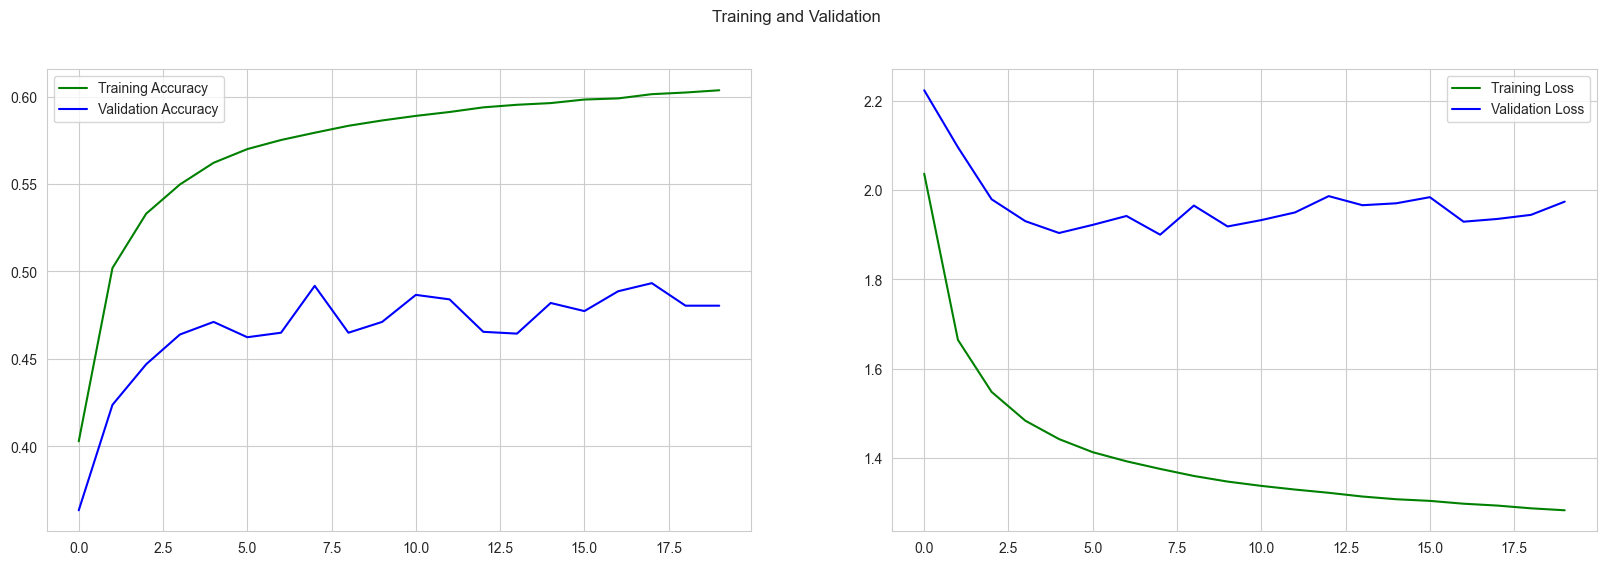

In [26]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,6))
ax[0].plot(epochs, acc, 'g', label = "Training Accuracy")
ax[0].plot(epochs, val_acc, 'b', label = "Validation Accuracy")
ax[0].legend(loc = 0)
ax[1].plot(epochs, loss, 'g', label = "Training Loss")
ax[1].plot(epochs, val_loss, 'b', label = "Validation Loss")
ax[1].legend(loc = 0)
plt.suptitle('Training and Validation')
plt.show()

## Text Prediction Functions

In [66]:
def prepare_input(text):
    x = np.zeros((1, sequence_length, len(character)))
    for t, char in enumerate(text):
        x[0, t, character_indices[char]] = 1.
    return x

In [74]:
def sample(preds, top_n = 3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [75]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose = 0)[0]
        next_index = sample(preds, top_n = 1)[0]
        next_char = indices_character[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [76]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose = 0)[0]
    next_indices = sample(preds, n)
    return [indices_character[idx] + predict_completion(text[1:] + indices_character[idx]) for idx in next_indices]

## Generate Predictions for Quotes

In [77]:
quotes = ["The only way to do great work is to love what you do.",
"In three words I can sum up everything I've learned about life: it goes on.",
"Success is not final, failure is not fatal: It is the courage to continue that counts.",
"The greatest glory in living lies not in never falling, but in rising every time we fall.",
"To be yourself in a world that is constantly trying to make you something else is the greatest accomplishment."]

## Print generated completions for each quote

In [78]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

the only way to do great work is to love
[' him ', 'r ', 's ', ', ', '. ']

in three words i can sum up everything i
['n ', ' have ', 't ', 'f ', 's ']

success is not final, failure is not fat
['her ', 'ely ', ' of ', 'sing ', 'tershat ']

the greatest glory in living lies not in
[' the ', 'to ', 'fluence ', 'nocent ', 'stantly ']

to be yourself in a world that is consta
['ble ', 'ged ', 'rted ', 'uless ', 'irs, ']

